# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import count, when, isnan, isnull, desc_nulls_first, desc, \
    from_unixtime, col, dayofweek, dayofyear, hour, to_date, month
import pyspark.sql.functions as F
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier

# sc = SparkContext(appName="Project_workspace")

# This is another way of doing (If you are running local cluster setMaster="local")
# configure = SparkConf().setAppName("name").setMaster("IP Address")
# sc = SparkContext(conf=configure)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("My Project App") \
        .getOrCreate()

In [3]:
# Check the current Spark Config
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1569287461764'),
 ('spark.driver.port', '44597'),
 ('spark.app.name', 'My Project App'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '35f50b8b8605'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
data = spark.read.json('mini_sparkify_event_data.json')

In [8]:
data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [53]:
data.count()

286500

In [54]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



We should look at the NULL values in our dataset. Based on the structure we may ommit some columns or impute if necessary for our analysis. Let's have a look at it both statistically and visually

First let's have a look if we have any NAN values in our dataset

In [55]:
data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).head().asDict()

{'artist': 0,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 0,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 0,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

Looks like we do not have any NAN values, that's good. How about NULL values?

In [56]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).head().asDict()

{'artist': 58392,
 'auth': 0,
 'firstName': 8346,
 'gender': 8346,
 'itemInSession': 0,
 'lastName': 8346,
 'length': 58392,
 'level': 0,
 'location': 8346,
 'method': 0,
 'page': 0,
 'registration': 8346,
 'sessionId': 0,
 'song': 58392,
 'status': 0,
 'ts': 0,
 'userAgent': 8346,
 'userId': 0}

We have plenty of NULL values particularly in certain columns, such as `artist`, `length` or `song` .

Other observation is that some there is a correlation in terms of null values count among columns, such as `artist`, `length` or `song` all have same number of NULL values. This is true for `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent`.

All other columns do not have any missing values. 

Also let's visually check missing values whether to see if our previous claim of correlation is supported. Not just NULL counts are the same but the rows numbers should be the same too.

Since pyspark do not have a visualizaton library, we sample and convert spark dataframe to pandas dataframe and visualize.

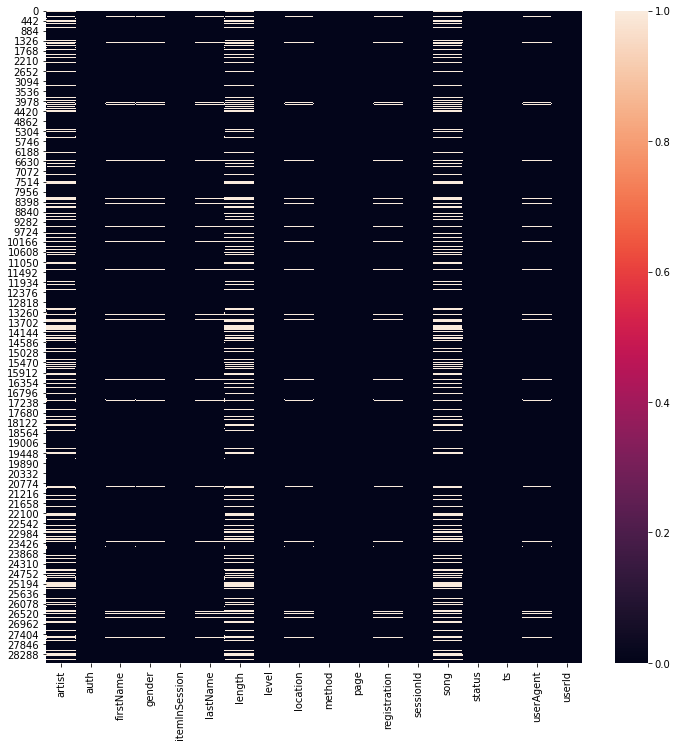

In [57]:
plt.figure(figsize=(12, 12))
sns.heatmap(data.sample(False, 0.1, 42).toPandas().isnull())

The heatmap plot above confirms our claim, columns are correlated in terms of mising values. 

One last thing I'd like to check if `firstName` and other similar fiels are NULL, are `artist` and similar fields are also NULL?

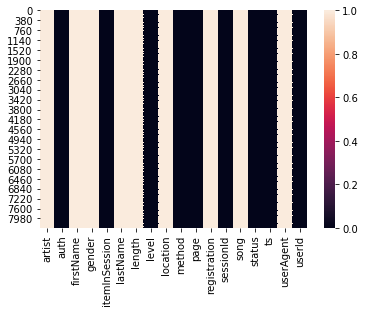

In [58]:
sns.heatmap(data.filter(data.firstName.isNull()).toPandas().isnull())

Yes, they are, so there is not only correlation inside groups where NULL counts are equal, but also inter groups NULL pattern is also correlated. In plain English, if `firstName` is NULL then `gender` is also null as their NULL count is equal, but the graph above also states `artist` col will be also NULL  

In [59]:
data.filter(data.firstName.isNull())\
    .groupBy('firstName','gender', 'lastName','location', 'registration','userAgent', 'auth')\
    .count()\
    .show()

+---------+------+--------+--------+------------+---------+----------+-----+
|firstName|gender|lastName|location|registration|userAgent|      auth|count|
+---------+------+--------+--------+------------+---------+----------+-----+
|     null|  null|    null|    null|        null|     null|Logged Out| 8249|
|     null|  null|    null|    null|        null|     null|     Guest|   97|
+---------+------+--------+--------+------------+---------+----------+-----+



In [60]:
data.groupBy('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out|  8249|
| Cancelled|    52|
|     Guest|    97|
| Logged In|278102|
+----------+------+



According to the two tables above, `fistName`, `gender`, `lastName`,`location`, `registration`,`userAgent` and  `auth` cols have NULL values when users are logged out or listening as Guest. Since we are really interested in users who are registered and likely to churn, we can remove these rows as they are not logged in users.  

In [61]:
data = data.na.drop(subset=['firstName','gender', 'lastName','location', 'registration','userAgent', 'auth'])

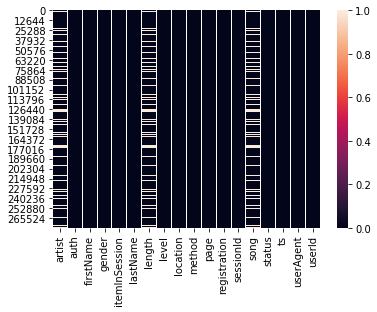

In [62]:
sns.heatmap(data.toPandas().isnull())

In [63]:
data = data\
    .withColumn('timestamp', from_unixtime(data.ts/1000))
#     .withColumn('hr', hour(col('timestamp')))\
#     .withColumn('dow', dayofweek(col('timestamp')))\
#     .withColumn('month', month(col('timestamp')))
#     .withColumn('date', to_date(col('timestamp')))\
#     .select('timestamp','date', 'hr','dow', "month")\
#     .sample(False, 0.1)\
#     .show()

In [64]:
data.take(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', timestamp='2018-10-01 00:01:57'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', timestamp='2018-10-01 00:03:00')]

For our model, we will be dropping some fields as we do not need them, maybe they have duplicate information in other column or just not relevant. 

In [65]:
cols_to_drop = ['userAgent', 'artist', 'firstName', 'lastName', 'location', 'song', 
                'ts', 'registration', 'length', 'method', 'status']

data = data.drop(*cols_to_drop)

data.show()

+---------+------+-------------+-----+---------------+---------+------+-------------------+
|     auth|gender|itemInSession|level|           page|sessionId|userId|          timestamp|
+---------+------+-------------+-----+---------------+---------+------+-------------------+
|Logged In|     M|           50| paid|       NextSong|       29|    30|2018-10-01 00:01:57|
|Logged In|     M|           79| free|       NextSong|        8|     9|2018-10-01 00:03:00|
|Logged In|     M|           51| paid|       NextSong|       29|    30|2018-10-01 00:06:34|
|Logged In|     M|           80| free|       NextSong|        8|     9|2018-10-01 00:06:56|
|Logged In|     M|           52| paid|       NextSong|       29|    30|2018-10-01 00:11:16|
|Logged In|     M|           81| free|       NextSong|        8|     9|2018-10-01 00:11:18|
|Logged In|     M|           82| free|       NextSong|        8|     9|2018-10-01 00:14:46|
|Logged In|     M|           53| paid|       NextSong|       29|    30|2018-10-0

In [66]:
data.groupBy('level', 'page').count().orderBy('level').show(100, truncate=False)

+-----+-------------------------+------+
|level|page                     |count |
+-----+-------------------------+------+
|free |Help                     |322   |
|free |Save Settings            |85    |
|free |Add Friend               |893   |
|free |Cancellation Confirmation|21    |
|free |Upgrade                  |499   |
|free |About                    |93    |
|free |Thumbs Down              |613   |
|free |NextSong                 |41991 |
|free |Thumbs Up                |2209  |
|free |Settings                 |360   |
|free |Home                     |2621  |
|free |Logout                   |922   |
|free |Error                    |53    |
|free |Add to Playlist          |1172  |
|free |Roll Advert              |3687  |
|free |Cancel                   |21    |
|free |Submit Upgrade           |159   |
|paid |Add Friend               |3384  |
|paid |Downgrade                |2055  |
|paid |Save Settings            |225   |
|paid |Home                     |7461  |
|paid |Error    

The table above tells us, both free and paid users can cancel their services, but only paid customers can downgrade services. Well, makes sense. I believe we can further filter down our dataframe as pages like **Settings** or **Help** won't tell much about churn.

In [67]:
pages_to_keep = ['NextSong', 'Downgrade', 'Cancellation Confirmation', 'Upgrade', 
                 'Add to Playlist', 'Cancel', 'Submit Upgrade', ]

data = data.filter(col('page').isin(pages_to_keep))

In [68]:
# We can either use page='Cancellation confirmation' or auth='Cancelled' as our label as their count match
data.groupBy('auth', 'page').count().orderBy('auth').show()

+---------+--------------------+------+
|     auth|                page| count|
+---------+--------------------+------+
|Cancelled|Cancellation Conf...|    52|
|Logged In|      Submit Upgrade|   159|
|Logged In|            NextSong|228108|
|Logged In|     Add to Playlist|  6526|
|Logged In|           Downgrade|  2055|
|Logged In|             Upgrade|   499|
|Logged In|              Cancel|    52|
+---------+--------------------+------+



In [69]:
# joined = user_features\
#     .join(churn_data_summary, 
#           on=['userId'], 
#           how='left')\
#     .join(user_engagement, 
#           on=['userId'], 
#           how='left')\
#     .join(listen_freq,
#           on=['userId'],
#           how='left')\
#     .orderBy('userId')\
#     .fillna(False, subset=['churned'])

# joined.show(40)

In [70]:
# joined.cache()

Numeric columns `sessionCount`, `meanSongCount` and `sessionsFreqDay` are all left skewed data, therefore before moving I'll apply `sqrt` or `log` transformations. Below are the transformations I decided for and the plots after transformation  

In [71]:
# joined_df = joined.toPandas()

In [72]:
# np.sqrt(joined_df['sessionsFreqDay']).hist()

In [73]:
# np.sqrt(joined_df['meanSongCount']).hist()

In [74]:
# np.log(joined_df['sessionCount']).hist()

In [75]:
# joined.show(4)

In [76]:
# joined = joined.withColumn('logSessionCount', F.log('sessionCount'))\
#       .withColumn('sqrtMeanSongCount', F.sqrt('meanSongCount'))\
#       .withColumn('sqrtSessionsFreqDay', F.sqrt('sessionsFreqDay'))
# joined.cache()
# joined.take(1)

In [77]:
# joined.groupBy('churned','gender').agg({'sessionCount': 'mean', 'meanSongCount': 'mean'}).show()

As expected churned users has overall lower mean value for `sessionCount` and `meanSongCount` per user

In [78]:
# grp_window = Window.partitionBy('churned')
# magic_percentile = F.expr('percentile_approx(meanSongCount, 0.5)')

# joined.withColumn('median', magic_percentile.over(grp_window)).select('churned', 'median').distinct().show()

In [79]:
# magic_percentile = F.expr('percentile_approx(sessionCount, 0.5)')

# joined.withColumn('median', magic_percentile.over(grp_window)).select('churned', 'median').distinct().show()

In [80]:
# from pyspark.ml.feature import StringIndexer

# joined = StringIndexer(inputCol='gender', outputCol='gender_idx')\
#                     .fit(joined)\
#                     .transform(joined)

# joined = StringIndexer(inputCol='level', outputCol='level_idx')\
#                     .fit(joined)\
#                     .transform(joined)

# joined = OneHotEncoderEstimator(inputCols=['gender_idx', 'level_idx'], outputCols=['gender_dummy','level_dummy'])\
#             .fit(joined)\
#             .transform(joined)

In [81]:
# joined.take(1)

In [82]:
# from pyspark.ml.feature import VectorAssembler

# joined_vector = VectorAssembler(inputCols=['gender_dummy', 'level_dummy', 'logSessionCount', 
#                                            'sqrtMeanSongCount', 'sqrtSessionsFreqDay'],
#                             outputCol='features').transform(joined)

# joined_vector.drop('userId','level','gender', 'sessionCount', 
#                    'meanSongCount', 'sessionsFreqDay', 'gender_idx', 'level_idx').show()

In [83]:
# from pyspark.ml.feature import StandardScaler, MinMaxScaler

# scaled = StandardScaler(inputCol="features", outputCol="scaledFeatures",
#                         withStd=True, withMean=False)\
#                         .fit(joined_vector)\
#                         .transform(joined_vector)

# minmaxscaled = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")\
#                              .fit(joined_vector)\
#                              .transform(joined_vector)

# scaled.select('features', 'scaledFeatures').take(2)

In [84]:
# minmaxscaled.select('features', 'scaledFeatures').take(2)

In [85]:
# df = minmaxscaled.withColumn('label', minmaxscaled.churned.cast('integer'))
# df.cache()

In [86]:
# df.take(1)

In [87]:
# train, test = df.randomSplit([0.8, 0.2], seed=42)

# from pyspark.ml.classification import DecisionTreeClassifier

# tree = DecisionTreeClassifier()
# tree_model = tree.fit(train)

In [88]:
# prediction = tree_model.transform(test)
# prediction.select('label', 'prediction', 'probability').show(20, False)

In [89]:
# prediction.groupBy('label', 'prediction').count().show()

Basic Decision tree classifier was fairly good indeed, it predicted 12 out of 17 churned users successfully in test dataset, and coulnd't predict 5 customers who churned. Also It predicted 3 customers were going to churn but didn't.

In [90]:
# from pyspark.ml.classification import LogisticRegression

# prediction_logistic = LogisticRegression().fit(train).transform(test)
# prediction_logistic.groupBy('label', 'prediction').count().show()

In [91]:
# from pyspark.ml.classification import GBTClassifier, RandomForestClassifier

# pred_forest = RandomForestClassifier().fit(train).transform(test)
# pred_forest.groupBy('label', 'prediction').count().show()

In [92]:
# pred_gbt = GBTClassifier().fit(train).transform(test)
# pred_gbt.groupBy('label', 'prediction').count().show()

In [93]:
# # Instead of min max scaling we can use standard scaled as our numeric values are roughly normally distributed
# df2 = scaled.withColumn('label', minmaxscaled.churned.cast('integer'))
# df2.cache()

In [94]:
# train2, test2 = df2.randomSplit([0.8, 0.2], seed=42)

# tree = DecisionTreeClassifier()
# prediction2 = tree.fit(train2).transform(test2)
# prediction2.groupBy('label', 'prediction').count().show()

In [95]:
# pred_forest2 = RandomForestClassifier().fit(train2).transform(test2)
# pred_forest2.groupBy('label', 'prediction').count().show()

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

**My Comment**: I agree wıth the definition above, `Cancellation Confirmation` is the most clear KPI for churn. `Downgrade` page is accessed hundreds of times but, data doesn't clearly tell us if users downgraded after accessing this page, such as we do not have `Downgrade Confirmed` followed by a `Downgrade` page. Also the number of `Downgrade` row in the dataset are far bigger than unique users. Therefore I sticked to the `Cancellation Confirmation` as the churn indicator.

In [96]:
# In our final dataset we do not have any null values
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).head().asDict()

{'auth': 0,
 'gender': 0,
 'itemInSession': 0,
 'level': 0,
 'page': 0,
 'sessionId': 0,
 'userId': 0,
 'timestamp': 0}

In [97]:
# We can either use page='Cancellation confirmation' or auth='Cancelled' as our label as their count match
data.groupBy('auth', 'page').count().orderBy('auth').show()

+---------+--------------------+------+
|     auth|                page| count|
+---------+--------------------+------+
|Cancelled|Cancellation Conf...|    52|
|Logged In|      Submit Upgrade|   159|
|Logged In|            NextSong|228108|
|Logged In|     Add to Playlist|  6526|
|Logged In|           Downgrade|  2055|
|Logged In|             Upgrade|   499|
|Logged In|              Cancel|    52|
+---------+--------------------+------+



*How many distinct users do we have in our dataset?*

In [98]:
data.select('userId').distinct().count()

225

*Let's have a look at a random user's listening activity. `itemInSession` increments monotonically for a continuous listening session. We may extract the max value for each session to understand user engagement (later in Feature Engineering section)*

In [99]:
data.filter(col('userId') == 30).show(100)

+---------+------+-------------+-----+---------------+---------+------+-------------------+
|     auth|gender|itemInSession|level|           page|sessionId|userId|          timestamp|
+---------+------+-------------+-----+---------------+---------+------+-------------------+
|Logged In|     M|           50| paid|       NextSong|       29|    30|2018-10-01 00:01:57|
|Logged In|     M|           51| paid|       NextSong|       29|    30|2018-10-01 00:06:34|
|Logged In|     M|           52| paid|       NextSong|       29|    30|2018-10-01 00:11:16|
|Logged In|     M|           53| paid|       NextSong|       29|    30|2018-10-01 00:14:59|
|Logged In|     M|           54| paid|Add to Playlist|       29|    30|2018-10-01 00:15:05|
|Logged In|     M|           55| paid|       NextSong|       29|    30|2018-10-01 00:18:04|
|Logged In|     M|           56| paid|       NextSong|       29|    30|2018-10-01 00:20:18|
|Logged In|     M|           57| paid|       NextSong|       29|    30|2018-10-0

*Let's have brief look at churned users/susbcribers* Looks like both `free` and `paid` customers can churn. We save this data to `churn_data` as we will use this in later when joining in Feature Engineering section*

In [100]:
churn_data = data.filter(col('page')=='Cancellation Confirmation')
churn_data.show(10)

+---------+------+-------------+-----+--------------------+---------+------+-------------------+
|     auth|gender|itemInSession|level|                page|sessionId|userId|          timestamp|
+---------+------+-------------+-----+--------------------+---------+------+-------------------+
|Cancelled|     M|          104| paid|Cancellation Conf...|      514|    18|2018-10-07 20:26:30|
|Cancelled|     M|           56| paid|Cancellation Conf...|      540|    32|2018-10-08 21:10:46|
|Cancelled|     M|           10| free|Cancellation Conf...|      174|   125|2018-10-12 04:35:18|
|Cancelled|     M|          332| paid|Cancellation Conf...|      508|   105|2018-10-12 20:17:21|
|Cancelled|     F|          273| paid|Cancellation Conf...|      797|    17|2018-10-13 21:19:44|
|Cancelled|     F|           29| free|Cancellation Conf...|      843|   143|2018-10-15 07:34:14|
|Cancelled|     M|          145| paid|Cancellation Conf...|      842|   101|2018-10-16 22:30:37|
|Cancelled|     M|           3

*We'll later need a list of chruned users when joining datasets in Feature engineering section, create a new column names `churned` *

In [101]:
churn_data_summary = churn_data.select('userId').withColumn('churned', F.lit(True))
churn_data_summary.show(10)

+------+-------+
|userId|churned|
+------+-------+
|    18|   true|
|    32|   true|
|   125|   true|
|   105|   true|
|    17|   true|
|   143|   true|
|   101|   true|
|   129|   true|
|   121|   true|
|    51|   true|
+------+-------+
only showing top 10 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

**One useful feature to measure user engagement would be to see how freqeuntly users are listening Sparkify platform.
We look at how many sessions a suser has and mean time between sessions would give us user engagement**

In [102]:
listen_freq = data.select('userId','sessionId', 'timeStamp')\
    .groupBy('userId','sessionId')\
    .agg(F.min('timeStamp').alias('sessionTime'))\
    .orderBy('userId', 'sessionId')\
    .groupBy('userId')\
    .agg(F.min('sessionTime').alias('minSessionTime'), 
         F.max('sessionTime').alias('maxSessionTime'),
         F.count('sessionId').alias('sessionCount'))\
    .withColumn('sessionsFreqDay', F.datediff('maxSessionTime', 'minSessionTime')/col('sessionCount'))\
    .orderBy('userId')

listen_freq.cache()
listen_freq.show(10)

+------+-------------------+-------------------+------------+------------------+
|userId|     minSessionTime|     maxSessionTime|sessionCount|   sessionsFreqDay|
+------+-------------------+-------------------+------------+------------------+
|    10|2018-10-08 02:20:20|2018-11-19 07:14:10|           6|               7.0|
|   100|2018-10-02 15:04:22|2018-11-30 08:44:40|          34|1.7352941176470589|
|100001|2018-10-01 06:48:29|2018-10-02 15:39:43|           4|              0.25|
|100002|2018-10-08 22:57:34|2018-12-03 01:11:16|           4|              14.0|
|100003|2018-10-09 15:53:40|2018-10-11 13:04:40|           2|               1.0|
|100004|2018-10-03 02:47:47|2018-11-28 19:35:21|          20|               2.8|
|100005|2018-10-01 15:16:56|2018-10-19 14:27:58|           4|               4.5|
|100006|2018-10-05 13:51:06|2018-10-05 13:51:06|           1|               0.0|
|100007|2018-10-02 07:30:03|2018-11-29 00:29:48|           9| 6.444444444444445|
|100008|2018-10-09 16:14:24|

In our model, we will only need the `sessionsFreqDay` as our feature and `userId` is the key for joining other datasets below, remanining columns are not necessary so we are filtering out

In [103]:
listen_freq = listen_freq.select('userId', 'sessionsFreqDay')
listen_freq.show(10)

+------+------------------+
|userId|   sessionsFreqDay|
+------+------------------+
|    10|               7.0|
|   100|1.7352941176470589|
|100001|              0.25|
|100002|              14.0|
|100003|               1.0|
|100004|               2.8|
|100005|               4.5|
|100006|               0.0|
|100007| 6.444444444444445|
|100008| 8.166666666666666|
+------+------------------+
only showing top 10 rows



*Below is a dataset showing each user's listening activity summary, how many sessions they listened and average song count for all sessions. These might be good indicators for churn prediction as these metrics are likely to relate to customer engagement.*

In [104]:
user_engagement = data\
    .groupBy('userId', 'sessionId')\
    .agg(F.max('itemInSession').alias('itemCount'))\
    .groupBy('userId')\
    .agg({"itemCount": "mean", "sessionId": "count"})\
    .withColumnRenamed('count(sessionId)', 'sessionCount')\
    .withColumnRenamed('avg(itemCount)', 'meanSongCount')\
    .orderBy('userId')

user_engagement.show(10)

+------+------------+------------------+
|userId|sessionCount|     meanSongCount|
+------+------------+------------------+
|    10|           6|133.66666666666666|
|   100|          34| 95.17647058823529|
|100001|           4|             48.75|
|100002|           4|             52.75|
|100003|           2|              41.0|
|100004|          20|              62.3|
|100005|           4|             52.75|
|100006|           1|              45.0|
|100007|           9|57.666666666666664|
|100008|           6|157.33333333333334|
+------+------------+------------------+
only showing top 10 rows



*Below is the SQL equivalent of the pyspark code above for `user_engagement`, I just added here for reference, it exactly gives the same data, but use a bit easier to read for reference. *

In [105]:
# Show that we can do the same calculation above using SQL
data.createOrReplaceTempView('sparkify')
sub_query = """

SELECT 
    userId, 
    sessionId, 
    max(itemInSession) as itemCount
FROM
    sparkify 
GROUP BY 
    userId, sessionId
ORDER BY 
    userId, sessionId
"""

query = """
SELECT 
    userId, 
    count(userId) as sessionCount, 
    avg(itemCount) as meanSongCount
FROM 
    ({sub_query})
GROUP BY 
    userId
ORDER BY
    userId
""".format(sub_query=sub_query)

spark.sql(query).show(10)

+------+------------+------------------+
|userId|sessionCount|     meanSongCount|
+------+------------+------------------+
|    10|           6|133.66666666666666|
|   100|          34| 95.17647058823529|
|100001|           4|             48.75|
|100002|           4|             52.75|
|100003|           2|              41.0|
|100004|          20|              62.3|
|100005|           4|             52.75|
|100006|           1|              45.0|
|100007|           9|57.666666666666664|
|100008|           6|157.33333333333334|
+------+------------+------------------+
only showing top 10 rows



*Information like `gender` and `level` are could be useful when predicting churn, let's save these features into `user_feature` dataframe*

In [106]:
user_features = data.select('gender', 'userid', 'level').distinct().orderBy('userId')
user_features.show(10)

+------+------+-----+
|gender|userid|level|
+------+------+-----+
|     M|    10| paid|
|     M|   100| paid|
|     M|   100| free|
|     F|100001| free|
|     F|100002| paid|
|     F|100003| free|
|     F|100004| free|
|     F|100004| paid|
|     M|100005| free|
|     F|100006| free|
+------+------+-----+
only showing top 10 rows



Finally, let's join all the features we have created above into a `joined` dataframe 

In [170]:
j.withColumn('churned', col('churned').cast('integer')).show(5)

+------+------+-----+-------+------------+------------------+------------------+
|userid|gender|level|churned|sessionCount|     meanSongCount|   sessionsFreqDay|
+------+------+-----+-------+------------+------------------+------------------+
|    10|     M| paid|      0|           6|133.66666666666666|               7.0|
|   100|     M| free|      0|          34| 95.17647058823529|1.7352941176470589|
|   100|     M| paid|      0|          34| 95.17647058823529|1.7352941176470589|
|100001|     F| free|      1|           4|             48.75|              0.25|
|100002|     F| paid|      0|           4|             52.75|              14.0|
+------+------+-----+-------+------------+------------------+------------------+
only showing top 5 rows



In [107]:
joined = user_features\
    .join(churn_data_summary, 
          on=['userId'], 
          how='left')\
    .join(user_engagement, 
          on=['userId'], 
          how='left')\
    .join(listen_freq,
          on=['userId'],
          how='left')\
    .orderBy('userId')\
    .fillna(False, subset=['churned'])
    .withColumn('churned', 
                col('churned').cast('integer'))

joined.cache()
joined.show(10)


+------+------+-----+-------+------------+------------------+------------------+
|userid|gender|level|churned|sessionCount|     meanSongCount|   sessionsFreqDay|
+------+------+-----+-------+------------+------------------+------------------+
|    10|     M| paid|  false|           6|133.66666666666666|               7.0|
|   100|     M| free|  false|          34| 95.17647058823529|1.7352941176470589|
|   100|     M| paid|  false|          34| 95.17647058823529|1.7352941176470589|
|100001|     F| free|   true|           4|             48.75|              0.25|
|100002|     F| paid|  false|           4|             52.75|              14.0|
|100003|     F| free|   true|           2|              41.0|               1.0|
|100004|     F| free|  false|          20|              62.3|               2.8|
|100004|     F| paid|  false|          20|              62.3|               2.8|
|100005|     M| free|   true|           4|             52.75|               4.5|
|100006|     F| free|   true

Now we have 5 prefictor columns for churn:
* `gender` : M or F
* `level`: **paid** or **free**
* `sessionCount`: How many continuous music session user listened to? Each session has many songs
* `meanSongCount`: For given sessions, what is the average number of songs a given user listened to? (How long a session)
* `sessionFreqDay`: What is the mean days between sessions, lower is better? Is the user frequently engaging? 

Before moving further, let's do a sanity check and see if our predictors make sense. Below is the mean value for `sessionCount` , `meanSongCount` and `SessionFreqDay` for each `churned` and `gender` group

In [108]:
joined.groupBy('churned','gender')\
      .agg({'sessionCount': 'mean', 
            'meanSongCount': 'mean',
            'sessionsFreqDay': 'mean'})\
      .orderBy('churned','gender')\
      .show()

+-------+------+------------------+------------------+--------------------+
|churned|gender| avg(sessionCount)|avg(meanSongCount)|avg(sessionsFreqDay)|
+-------+------+------------------+------------------+--------------------+
|  false|     F| 19.88888888888889| 98.62965782415098|   4.223329936963134|
|  false|     M|13.161971830985916| 90.76005648725896|   4.961284649317968|
|   true|     F|11.545454545454545|  87.8641758596867|  2.5817654309914375|
|   true|     M|11.081632653061224| 84.50908891295447|   2.239359261520126|
+-------+------+------------------+------------------+--------------------+



Churned users tend to have lower `sessionCount`s listen to less number of music in sessions, and but engages with platform less frequently *(2 - 2.5 days between sessions for churned users and 4 - 4.8 days for non-churned users)* This is a bit contrary to gut feeling, but nevertheless useful predictor. One interesting finding is that female users are more engaged with the platform than Males, this will be also useful for our model

In [109]:
joined.groupBy('churned','level')\
      .agg({'sessionCount': 'mean', 
            'meanSongCount': 'mean',
            'sessionsFreqDay': 'mean'})\
      .orderBy('churned','level')\
      .show()

+-------+-----+------------------+------------------+--------------------+
|churned|level| avg(sessionCount)|avg(meanSongCount)|avg(sessionsFreqDay)|
+-------+-----+------------------+------------------+--------------------+
|  false| free|15.187919463087248| 84.10800173498525|   4.905300046578652|
|  false| paid|        17.8984375|106.80343413233099|   4.248142615257462|
|   true| free|              10.5|  76.7782227547583|  2.2521639702111504|
|   true| paid|             12.25| 97.46291426070968|   2.536870011319186|
+-------+-----+------------------+------------------+--------------------+



When we look at the data from the perspective of *free* or *paid* users, there are some interesting facts. `sessionCount` and `meanSongCount` both are higher for non-churned users as expected, however again churned users engaged with the platform more frequently. Does this mean they churned not because of their lack of interest but because they are annoyed they cannot find the musics they are looking and left the platform because of that? This would be interesting to explore indeed

Just to make sure we are not falling into the statistical fallacy of Simpson's paradox let's have a look at both `level` and `gender` together.

In [110]:
joined.groupBy('churned','level', 'gender')\
      .agg({'sessionCount': 'mean', 
            'meanSongCount': 'mean',
            'sessionsFreqDay': 'mean'})\
      .orderBy('churned','level', 'gender')\
      .show()

+-------+-----+------+------------------+------------------+--------------------+
|churned|level|gender| avg(sessionCount)|avg(meanSongCount)|avg(sessionsFreqDay)|
+-------+-----+------+------------------+------------------+--------------------+
|  false| free|     F|18.614285714285714| 89.27228099662196|   4.443434454791594|
|  false| free|     M|12.151898734177216| 79.53205808543368|   5.314548039301365|
|  false| paid|     F| 21.26153846153846|108.70683286918226|   3.986294302378639|
|  false| paid|     M|14.428571428571429|104.83961003875422|  4.5183035729895815|
|   true| free|     F|10.842105263157896|  81.1982755272718|  2.3536091608317453|
|   true| free|     M| 10.25925925925926| 73.66781524817473|   2.180776613848509|
|   true| paid|     F|              12.5|  96.9107548822498|  2.8914060833510193|
|   true| paid|     M|12.090909090909092| 97.81428841063867|  2.3112561472989275|
+-------+-----+------+------------------+------------------+--------------------+



Machine learning models in Spark works only with numbers, therefore we need to transform our categorical features into numbers.

We will be using `StringIndexer`, to assign numbers to `level` and `gender` and use `OneHotEncoderEstimator` to encode them into `SparseVector`.

In [111]:
joined = StringIndexer(inputCol='gender', outputCol='gender_idx')\
            .fit(joined)\
            .transform(joined)

joined = StringIndexer(inputCol='level', outputCol='level_idx')\
            .fit(joined)\
            .transform(joined)

joined = OneHotEncoderEstimator(inputCols=['gender_idx', 'level_idx'], 
                                outputCols=['gender_dummy','level_dummy'])\
            .fit(joined)\
            .transform(joined)

In [112]:
# Dropping gender and level (temporarily), just to fit the cell into screen for readability
joined.drop('gender', 'level').show()

+------+-------+------------+------------------+------------------+----------+---------+-------------+-------------+
|userid|churned|sessionCount|     meanSongCount|   sessionsFreqDay|gender_idx|level_idx| gender_dummy|  level_dummy|
+------+-------+------------+------------------+------------------+----------+---------+-------------+-------------+
|    10|  false|           6|133.66666666666666|               7.0|       0.0|      1.0|(1,[0],[1.0])|    (1,[],[])|
|   100|  false|          34| 95.17647058823529|1.7352941176470589|       0.0|      0.0|(1,[0],[1.0])|(1,[0],[1.0])|
|   100|  false|          34| 95.17647058823529|1.7352941176470589|       0.0|      1.0|(1,[0],[1.0])|    (1,[],[])|
|100001|   true|           4|             48.75|              0.25|       1.0|      0.0|    (1,[],[])|(1,[0],[1.0])|
|100002|  false|           4|             52.75|              14.0|       1.0|      1.0|    (1,[],[])|    (1,[],[])|
|100003|   true|           2|              41.0|               1

If the data is skewed in numerical columns predictor strength decreases, therfore we also should check distribution of our numerical columns `sessionCount`, `meanSongCount` and `sessionsFreqDay`. Let's check visually

In [113]:
joined_pandas = joined.select('sessionCount', 'meanSongCount', 'sessionsFreqDay').toPandas()

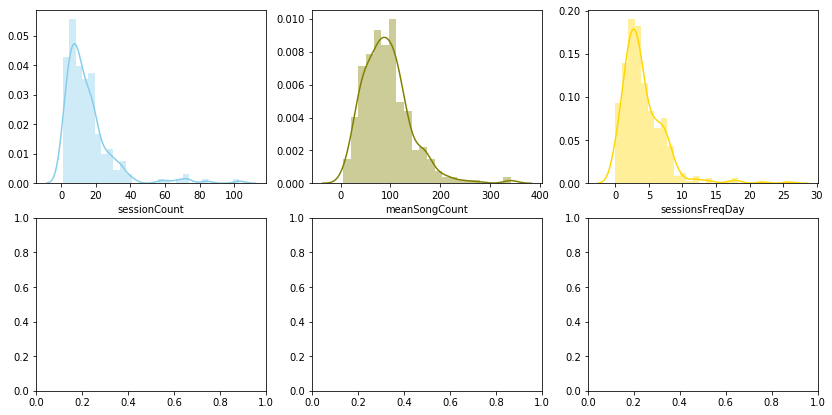

In [114]:
f, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=False)
sns.distplot( joined_pandas["sessionCount"] , color="skyblue", ax=axes[0, 0])
sns.distplot( joined_pandas["meanSongCount"] , color="olive", ax=axes[0, 1])
sns.distplot( joined_pandas["sessionsFreqDay"] , color="gold", ax=axes[0, 2])


All looks skewed to left, let's apply `log` and `sqrt` transforms to handle skew

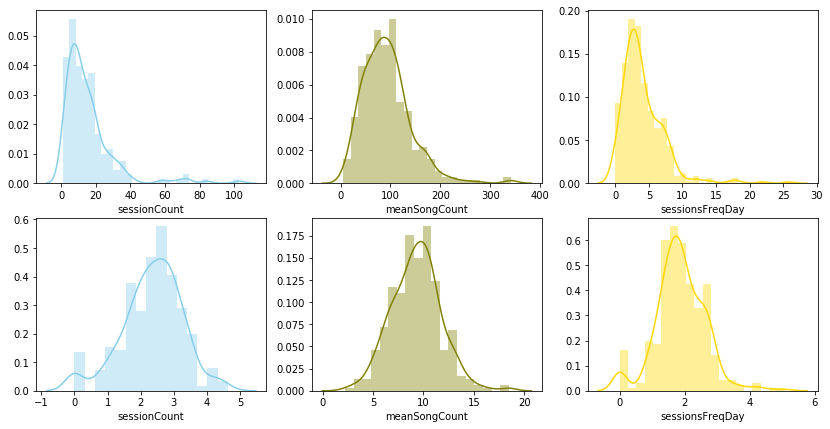

In [115]:
f, axes = plt.subplots(2, 3, figsize=(14, 7), sharex=False)
sns.distplot( joined_pandas["sessionCount"] , color="skyblue", ax=axes[0, 0])
sns.distplot( joined_pandas["meanSongCount"] , color="olive", ax=axes[0, 1])
sns.distplot( joined_pandas["sessionsFreqDay"] , color="gold", ax=axes[0, 2])

# Skew handling
sns.distplot( np.log(joined_pandas["sessionCount"]) , color="skyblue", ax=axes[1, 0])
sns.distplot( np.sqrt(joined_pandas["meanSongCount"]) , color="olive", ax=axes[1, 1])
sns.distplot( np.sqrt(joined_pandas["sessionsFreqDay"]) , color="gold", ax=axes[1, 2])

This looks better, we go back to our spark DataFrame `joined` and apply transformations there. 

In [116]:
joined = joined.withColumn('logSessionCount', F.log('sessionCount'))\
      .withColumn('sqrtMeanSongCount', F.sqrt('meanSongCount'))\
      .withColumn('sqrtSessionsFreqDay', F.sqrt('sessionsFreqDay'))
joined.cache()
joined.take(1)

[Row(userid='10', gender='M', level='paid', churned=False, sessionCount=6, meanSongCount=133.66666666666666, sessionsFreqDay=7.0, gender_idx=0.0, level_idx=1.0, gender_dummy=SparseVector(1, {0: 1.0}), level_dummy=SparseVector(1, {}), logSessionCount=1.791759469228055, sqrtMeanSongCount=11.561430130683084, sqrtSessionsFreqDay=2.6457513110645907)]

Finally, we need to create two columns, `label` and `features`. Spark ML needs the `label` column and it ahs to be number, this means we need to convert `churned` column to `label` by casting to integer

We also need all predictors to be in a vector, Spark ML works on vectors, so we need to join all these 5 predictors.

In [117]:
joined_vector = VectorAssembler(inputCols=['gender_dummy', 'level_dummy', 'logSessionCount', 
                                           'sqrtMeanSongCount', 'sqrtSessionsFreqDay'],
                                outputCol='nonScaledFeatures')\
                                .transform(joined)

joined_vector = joined_vector.withColumn('label', joined_vector.churned.cast('integer'))

joined_vector.drop('userId','level','gender', 'sessionCount', 'meanSongCount', 
                   'sessionsFreqDay', 'gender_idx', 'level_idx', 'churned').show(4)

+-------------+-------------+------------------+------------------+-------------------+--------------------+-----+
| gender_dummy|  level_dummy|   logSessionCount| sqrtMeanSongCount|sqrtSessionsFreqDay|   nonScaledFeatures|label|
+-------------+-------------+------------------+------------------+-------------------+--------------------+-----+
|(1,[0],[1.0])|    (1,[],[])| 1.791759469228055|11.561430130683084| 2.6457513110645907|[1.0,0.0,1.791759...|    0|
|(1,[0],[1.0])|(1,[0],[1.0])|3.5263605246161616| 9.755842894811051| 1.3173056280328643|[1.0,1.0,3.526360...|    0|
|(1,[0],[1.0])|    (1,[],[])|3.5263605246161616| 9.755842894811051| 1.3173056280328643|[1.0,0.0,3.526360...|    0|
|    (1,[],[])|(1,[0],[1.0])|1.3862943611198906|  6.98212002188447|                0.5|[0.0,1.0,1.386294...|    1|
+-------------+-------------+------------------+------------------+-------------------+--------------------+-----+
only showing top 4 rows



Focusing on only the `nonScaledFeatures` and `label`:

In [118]:
joined_vector.select('nonScaledFeatures', 'label').show(10, truncate=False)

+-----------------------------------------------------------------+-----+
|nonScaledFeatures                                                |label|
+-----------------------------------------------------------------+-----+
|[1.0,0.0,1.791759469228055,11.561430130683084,2.6457513110645907]|0    |
|[1.0,1.0,3.5263605246161616,9.755842894811051,1.3173056280328643]|0    |
|[1.0,0.0,3.5263605246161616,9.755842894811051,1.3173056280328643]|0    |
|[0.0,1.0,1.3862943611198906,6.98212002188447,0.5]                |1    |
|[0.0,0.0,1.3862943611198906,7.262919523166975,3.7416573867739413]|0    |
|[0.0,1.0,0.6931471805599453,6.4031242374328485,1.0]              |1    |
|[0.0,1.0,2.995732273553991,7.893034904268446,1.6733200530681511] |0    |
|[0.0,0.0,2.995732273553991,7.893034904268446,1.6733200530681511] |0    |
|[1.0,1.0,1.3862943611198906,7.262919523166975,2.1213203435596424]|1    |
|(5,[1,3],[1.0,6.708203932499369])                                |1    |
+-------------------------------------

Mechine learning models work with standardized data better, therefore we need to standardize our features before moving to Modelling phase

In [119]:
scaled = StandardScaler(inputCol="nonScaledFeatures", outputCol="features",
                        withStd=True, withMean=True)\
                        .fit(joined_vector)\
                        .transform(joined_vector)

In [120]:
scaled.select('features', 'label').show(10, truncate=False)

+-----------------------------------------------------------------------------------------------------+-----+
|features                                                                                             |label|
+-----------------------------------------------------------------------------------------------------+-----+
|[0.936552756153413,-1.0889041944030828,-0.6180079480153943,0.9170586536337896,1.0118681455914553]    |0    |
|[0.936552756153413,0.915796348113362,1.29029237648804,0.18372872275680666,-0.7314772101603136]       |0    |
|[0.936552756153413,-1.0889041944030828,1.29029237648804,0.18372872275680666,-0.7314772101603136]     |0    |
|[-1.0647712882458444,0.915796348113362,-1.0640754717115033,-0.9428044971641809,-1.804043434779411]   |1    |
|[-1.0647712882458444,-1.0889041944030828,-1.0640754717115033,-0.8287592299099853,2.4500472084101004] |0    |
|[-1.0647712882458444,0.915796348113362,-1.8266329401751844,-1.1779606447899746,-1.1478836165724766]  |1    |
|[-1.06477

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

We evaluate two models, `DecisionTreeClassifier` and `RandomForestClassifier`. `RandomForestClassifer` would combine many `DecisionTreeClassifiers` to get a better accuracy by making the classifier less prone to overfitting. `DecisionTreeClassifer` tends to overfit in general.

Our first model is `DecisionTreeClassifier` with default inputs

In [124]:
train, test = scaled.randomSplit([0.8, 0.2], seed=42)

tree = DecisionTreeClassifier()
prediction_tree = tree.fit(train).transform(test)
prediction_tree.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    8|
|    0|       0.0|   51|
|    1|       1.0|    9|
|    0|       1.0|    2|
+-----+----------+-----+



For a deeper insight we can have a look at probability values for each prediction

In [125]:
prediction_tree.select('label', 'prediction', 'probability').show(20, False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0    |0.0       |[0.9052631578947369,0.09473684210526316] |
|0    |0.0       |[0.9052631578947369,0.09473684210526316] |
|0    |0.0       |[0.9052631578947369,0.09473684210526316] |
|1    |0.0       |[0.7777777777777778,0.2222222222222222]  |
|0    |0.0       |[1.0,0.0]                                |
|1    |1.0       |[0.18181818181818182,0.8181818181818182] |
|1    |1.0       |[0.4,0.6]                                |
|1    |1.0       |[0.4,0.6]                                |
|1    |1.0       |[0.045454545454545456,0.9545454545454546]|
|1    |1.0       |[0.18181818181818182,0.8181818181818182] |
|0    |0.0       |[1.0,0.0]                                |
|0    |0.0       |[0.9052631578947369,0.09473684210526316] |
|0    |0.0       |[1.0,0.0]                                |
|0    |0.0       |[1.0,0

Churn event is rather sparse, and basic Decision tree classifier was able to predict 9 churn events successfully and missed 8,and incorrectly predicted 2 customers were going to churn but didn't.

Now we look at `RandomForestClassifier` with default hyperparameters

In [126]:
prediction_forest = RandomForestClassifier().fit(train).transform(test)
prediction_forest.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    9|
|    0|       0.0|   52|
|    1|       1.0|    8|
|    0|       1.0|    1|
+-----+----------+-----+



RandomForest didn't perform particularly better in this case compared to DecisionTreeClassifier

In [130]:
minmaxscaled = MinMaxScaler(inputCol="nonScaledFeatures", outputCol="features")\
                        .fit(joined_vector)\
                        .transform(joined_vector)
minmaxscaled.select('features', 'label').show(10, truncate=False)

+--------------------------------------------------------------------+-----+
|features                                                            |label|
+--------------------------------------------------------------------+-----+
|[1.0,0.0,0.3865942267128045,0.5744649790503206,0.5188745216627709]  |0    |
|[1.0,1.0,0.760855819956617,0.4632364158491928,0.25834488856558363]  |0    |
|[1.0,0.0,0.760855819956617,0.4632364158491928,0.25834488856558363]  |0    |
|[0.0,1.0,0.29911012372903045,0.292368343820136,0.09805806756909202] |1    |
|[0.0,0.0,0.29911012372903045,0.30966627573654204,0.7337993857053429]|0    |
|[0.0,1.0,0.14955506186451523,0.2567007959306758,0.19611613513818404]|1    |
|[0.0,1.0,0.646366223604866,0.3484829150538877,0.3281650616569468]   |0    |
|[0.0,0.0,0.646366223604866,0.3484829150538877,0.3281650616569468]   |0    |
|[1.0,1.0,0.29911012372903045,0.30966627573654204,0.4160251471689218]|1    |
|[0.0,1.0,0.0,0.275494446810523,0.0]                                 |1    |

In [135]:
train, test = minmaxscaled.randomSplit([0.8, 0.2], seed=42)

tree = DecisionTreeClassifier(featuresCol='nonScaledFeatures', labelCol='label')
prediction_tree = tree.fit(train).transform(test)
prediction_tree.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    8|
|    0|       0.0|   51|
|    1|       1.0|    9|
|    0|       1.0|    2|
+-----+----------+-----+



In [143]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='nonScaledFeatures', labelCol='label')
pred_gbt = gbt.fit(train).transform(test)
pred_gbt.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    6|
|    0|       0.0|   51|
|    1|       1.0|   11|
|    0|       1.0|    2|
+-----+----------+-----+



In [147]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='label')
pred_gbt = gbt.fit(train).transform(test)
pred_gbt.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    6|
|    0|       0.0|   51|
|    1|       1.0|   11|
|    0|       1.0|    2|
+-----+----------+-----+



In [145]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Find AUC
binary_evaluator = BinaryClassificationEvaluator()
auc = binary_evaluator.evaluate(pred_gbt, {binary_evaluator.metricName: "areaUnderROC"})

In [152]:
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

params = ParamGridBuilder().build()

cv = CrossValidator(estimator=tree, estimatorParamMaps=params, evaluator=binary_evaluator, numFolds=5)
cv = cv.fit(train)

In [156]:
pred_cv = cv.transform(test)
pred_cv.groupBy('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    8|
|    0|       0.0|   51|
|    1|       1.0|    9|
|    0|       1.0|    2|
+-----+----------+-----+



In [184]:
j.show()

+------+------+-----+-------+------------+------------------+------------------+
|userid|gender|level|churned|sessionCount|     meanSongCount|   sessionsFreqDay|
+------+------+-----+-------+------------+------------------+------------------+
|    10|     M| paid|      0|           6|133.66666666666666|               7.0|
|   100|     M| free|      0|          34| 95.17647058823529|1.7352941176470589|
|   100|     M| paid|      0|          34| 95.17647058823529|1.7352941176470589|
|100001|     F| free|      1|           4|             48.75|              0.25|
|100002|     F| paid|      0|           4|             52.75|              14.0|
|100003|     F| free|      1|           2|              41.0|               1.0|
|100004|     F| free|      0|          20|              62.3|               2.8|
|100004|     F| paid|      0|          20|              62.3|               2.8|
|100005|     M| free|      1|           4|             52.75|               4.5|
|100006|     F| free|      1

In [185]:
j = user_features\
    .join(churn_data_summary, 
          on=['userId'], 
          how='left')\
    .join(user_engagement, 
          on=['userId'], 
          how='left')\
    .join(listen_freq,
          on=['userId'],
          how='left')\
    .orderBy('userId')\
    .fillna(False, subset=['churned'])\
    .withColumn('churned', 
                col('churned').cast('integer'))\
    .withColumn('logSessionCount', F.log('sessionCount'))\
    .withColumn('sqrtMeanSongCount', F.sqrt('meanSongCount'))\
    .withColumn('sqrtSessionsFreqDay', F.sqrt('sessionsFreqDay'))

j.cache()
j.show(5)

+------+------+-----+-------+------------+------------------+------------------+------------------+------------------+-------------------+
|userid|gender|level|churned|sessionCount|     meanSongCount|   sessionsFreqDay|   logSessionCount| sqrtMeanSongCount|sqrtSessionsFreqDay|
+------+------+-----+-------+------------+------------------+------------------+------------------+------------------+-------------------+
|    10|     M| paid|      0|           6|133.66666666666666|               7.0| 1.791759469228055|11.561430130683084| 2.6457513110645907|
|   100|     M| free|      0|          34| 95.17647058823529|1.7352941176470589|3.5263605246161616| 9.755842894811051| 1.3173056280328643|
|   100|     M| paid|      0|          34| 95.17647058823529|1.7352941176470589|3.5263605246161616| 9.755842894811051| 1.3173056280328643|
|100001|     F| free|      1|           4|             48.75|              0.25|1.3862943611198906|  6.98212002188447|                0.5|
|100002|     F| paid|      

[StringIndexer_fba551e63d6c, StringIndexer_f0185a91cdec]

In [191]:
# Keep a list for Pipeline stages
stages = []

# Convert categorical variables to indexes
indexers = [StringIndexer(inputCol=column, outputCol=column+"_idx").fit(j) for column in ['level', 'gender']]

# Convert indexes to OnHotEncoded Sparse Vectors
onehotencoder = OneHotEncoderEstimator(inputCols=['gender_idx', 'level_idx'], 
                                       outputCols=['gender_dummy','level_dummy'])

# Assemble all predictor values to "nonScaledFatures" Dense vector
assembler = VectorAssembler(inputCols=['gender_dummy', 'level_dummy', 'logSessionCount', 
                                       'sqrtMeanSongCount', 'sqrtSessionsFreqDay'],
                            outputCol='nonScaledFeatures')

# Scale the features, depends on the classifier you can pick scaled or non scaled features
scalers = [
    MinMaxScaler(inputCol="nonScaledFeatures", outputCol="minMaxScaledFeatures"),
    StandardScaler(inputCol="nonScaledFeatures", outputCol="stdScaledFeatures", withStd=True, withMean=True)
]

# Define RandomForestClassifer with features(predictors) and label
classifier = RandomForestClassifier(featuresCol='nonScaledFeatures', labelCol='churned')

# Add all to stages
stages += indexers
stages.append(onehotencoder)
stages.append(assembler)
stages += scalers
stages.append(classifier)


stages

[StringIndexer_68305429c317,
 StringIndexer_c98ace58d733,
 OneHotEncoderEstimator_0216ca1e6769,
 VectorAssembler_45b1ace90533,
 MinMaxScaler_bfcb63301c7e,
 StandardScaler_dd543c1f0b07,
 RandomForestClassifier_dce35260ff2f]

In [200]:
params = ParamGridBuilder()

In [203]:
params = ParamGridBuilder()\
    .addGrid(classifier.maxDepth, [2, 5, 10])\
    .addGrid(classifier.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2'])\
    .build()

evaluator = binary_evaluator = BinaryClassificationEvaluator(labelCol='churned')

pipeline = Pipeline(stages=stages)

cv = CrossValidator(estimator=pipeline,
          estimatorParamMaps=params,
          evaluator=evaluator, 
          numFolds=5)

`CrossValidator` will run GridSearch on all hypermodels and also will fit `numFolds` of crossvalidation. This much of model fitting may take some time

In [209]:
"Number of models to be tested with 5 crossfolds = {}".format(5*len(params))

'Number of models to be tested with 5 crossfolds = 60'

In [210]:
train, test = j.randomSplit([0.8, 0.2], seed=42)
model = cv.fit(train)

In [211]:
model.avgMetrics

[0.833184584172826,
 0.8297167474183151,
 0.8203765079904897,
 0.8203765079904897,
 0.7988566572605127,
 0.8019411267823522,
 0.8013008528026124,
 0.8013008528026124,
 0.8038614473032966,
 0.8042281111146093,
 0.8256818561377832,
 0.8256818561377831]

In [222]:
predictions = model.transform(test)

In [ ]:
predictions.groupBy('churned', 'prediction').count().show()

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.